# Midterm 1

## FINM 36700 - 2024

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

# Instructions

## Please note the following:

Points
* The exam is `100` points.
* You have `125` minutes to complete the exam.
* For every minute late you submit the exam, you will lose one point.


Submission
* You will upload your solution to the `Midterm 1` assignment on Canvas, where you downloaded this. (Be sure to **submit** on Canvas, not just **save** on Canvas.
* Your submission should be readable, (the graders can understand your answers,)
* and it should **include all code used in your analysis in a file format that the code can be executed.** 

Rules
* The exam is open-material, closed-communication.
* You do not need to cite material from the course github repo--you are welcome to use the code posted there without citation.

Advice
* If you find any question to be unclear, state your interpretation and proceed. We will only answer questions of interpretation if there is a typo, error, etc.
* The exam will be graded for partial credit.

## Data

**All data files are found in the class github repo, in the `data` folder.**

This exam makes use of the following data files:
* `midterm_1_data.xlsx`

This file has sheets for...
* `stocks excess returns` - excess returns of the 14 biggest companies in the S&P.
* `proshares excess returns` - excess returns of ETFs and indexes from the Proshares case study.
* `fx carry excess returns` - excess returns from FX products.

Note the data is **monthly** for the first two sheets (stocks and proshares). Any annualizations for those two sheets should use `12` months in a year. Annualization for the third sheet (fx carry excess returns) is explained in section 4.

## Scoring

| Problem | Points |
|---------|--------|
| 1       | 15     |
| 2       | 25     |
| 3       | 35     |
| 4       | 25     |

### Each numbered question is worth 5 points unless otherwise specified.

***

# Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import os
from arch import arch_model
import re
import sys
import matplotlib.pyplot as plt
from scipy.stats import norm
current_dir = os.getcwd()
import seaborn as sns
sns.set_style("whitegrid")
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
grandparent_dir = os.path.abspath(os.path.join(parent_dir, os.pardir))

PLOT_WIDTH, PLOT_HEIGHT = 8, 5
COLORS = ["blue", "red", "orange"]

sys.path.insert(0, parent_dir)
sys.path.insert(0, grandparent_dir)
import cmds.portfolio_management_helper as pmh

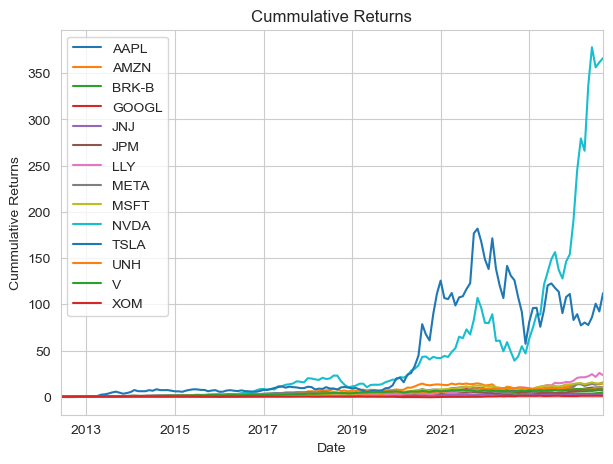

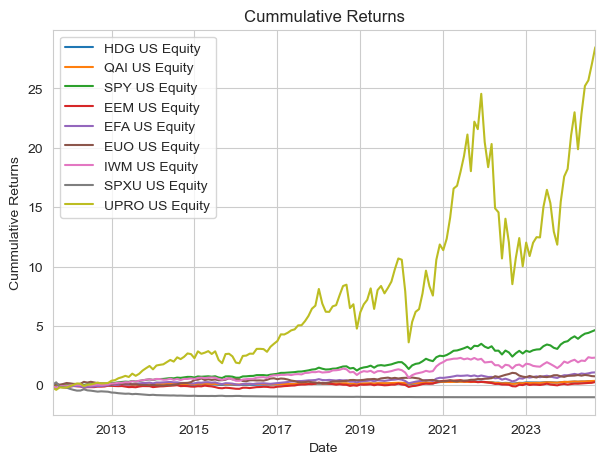

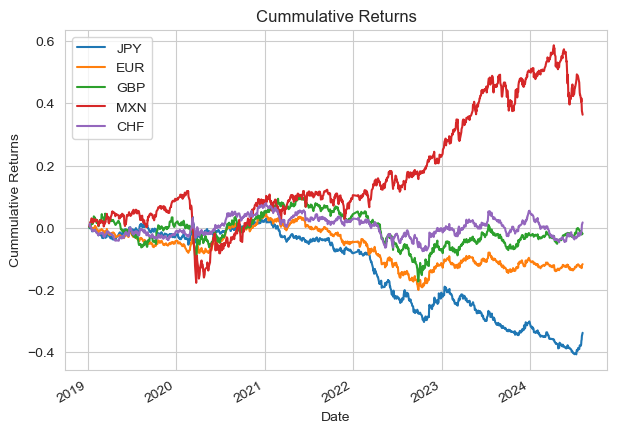

In [3]:
stocksx = pmh.read_excel_default("../data/midterm_1_data.xlsx", sheet_name=0)
prosx = pmh.read_excel_default("../data/midterm_1_data.xlsx", sheet_name=1)
forexx = pmh.read_excel_default("../data/midterm_1_data.xlsx", sheet_name=2)
pmh.calc_cummulative_returns(stocksx)
pmh.calc_cummulative_returns(prosx)
pmh.calc_cummulative_returns(forexx)

# 1. Short Answer

#### No Data Needed

These problems do not require any data file. Rather, analyze them conceptually. 

### 1.

#### (10pts)

In the mean-variance optimization of `homework 1`, suppose we found the mean excess return of TIPS is 4% annualized.

Explain--conceptually--how each of the following would have impacted the new (with TIPS) MV solution.
* TIPS is found to have correlation of 0% to `IEF` and 0% to SPY.
* TIPS is found to have correlation of 100% to `IEF`.

Would it be possible for TIPS to have been found to have 0% correlation to every other asset in `homework 1`? Explain.

<span style="color:red;">

* 0% correlation to IEF and SPY would have led the MV solution to allocate a sizable portion of the portfolio to TIPS. This is because the annualized returns are better than other bond assets, and the low correlations with assets that had a sizeable allocation in the portfolio would have provided a significant risk-reducing effect.

* IEF would have an even bigger short position in the MV solution so that we could go long even more of TIPS because of the better return profile and Sharpe raito of TIPS.

No, this would not be possible. The cross-section of assets was too large and these assets trade in similar markets. Therefore the return profiles would be too similar to provide a 0% correlation. Additionally, TIPS is simply an inflation-adjusted version of domestic bonds, so it should be quite highly correlated with those assets.

<span>

### 2. 

Depending on the application, one may or may not choose to include an intercept term in a linear factor decomposition of an asset’s returns. In what circumstances would I prefer to include an intercept, and in what circumstances would I not?

<span style="color:red">

* **Include an intercept** When you are a replicator and you believe the mean returns are not well estimated by a regression model. In this way, you are only concerned with replicating by matching the variance of the asset you are trying to replicate.

* **Exclude an intercept** When you are a replicator and believe the mean returns are well estimated by a regression model. In this way, you force the betas to only model the variance of the asset to be replicated, but also the return level.

<span>

***

# 2. Portfolio Allocation

For this question you will only use data from the sheet `stocks excess returns`.

It contains excess returns for the 14 largest stocks in the S&P.

,AAPL,AMZN,BRK-B,GOOGL,JNJ,JPM,LLY,META,MSFT,NVDA,TSLA,UNH,V,XOM
date,,,,,,,,,,,,,,
2012-06-30,0.0109,0.0726,0.0501,-0.0013,0.0823,0.0779,0.0480,0.0508,0.0481,0.1119,0.0608,0.0529,0.0733,0.0884
2012-07-31,0.0458,0.0217,0.0181,0.0912,0.0246,0.0160,0.0261,-0.3019,-0.0366,-0.0203,-0.1237,-0.1267,0.0440,0.0150
2012-08-31,0.0937,0.0640,-0.0061,0.0822,-0.0172,0.0315,0.0314,-0.1683,0.0526,0.0360,0.0399,0.0626,-0.0048,0.0115
2012-09-30,0.0029,0.0245,0.0458,0.1014,0.0220,0.0900,0.0557,0.1994,-0.0343,-0.0491,0.0267,0.0247,0.0471,0.0476
2012-10-31,-0.1075,-0.0842,-0.0209,-0.0983,0.0278,0.0373,0.0258,-0.0253,-0.0409,-0.1019,-0.0392,0.0107,0.0334,-0.0030


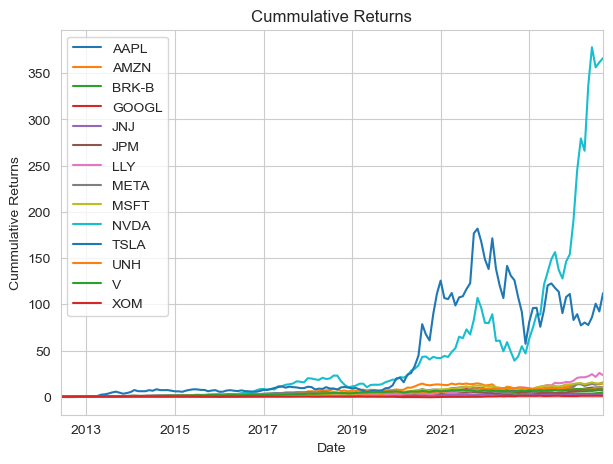

In [4]:
stocksx = pmh.read_excel_default("../data/midterm_1_data.xlsx", sheet_name=0)
pmh.calc_cummulative_returns(stocksx)
display(stocksx.head())

### 1.

Calculate the tangency portfolio from the start of the sample to December of 2018 (to 2018-12-31), which we call in-sample period. Use the following methods:
- Traditional tangency portfolio.
- Regularized tangency portfolio (divide by 2 every element outside of the diagonal in the covariance matrix prior to the calculation).

Return:
- The weights of each asset for the traditional tangency portfolio and the regularized tangency portfolio.
- The sum of absolute values of the weights for the traditional tangency portfolio and the regularized tangency portfolio:

$$
\sum_{i=1}^{n} |w_i|
$$


In [5]:
IN_SAMPLE_END_DATE = "2018-12-31"
OUT_OF_SAMPLE_START_DATE = "2019-01-01"

in_sample_assets_excess_returns = stocksx.loc[:IN_SAMPLE_END_DATE]
out_of_sample_assets_excess_returns = stocksx.loc[OUT_OF_SAMPLE_START_DATE:]

,Tangency Weights
AAPL,-0.1278
AMZN,-0.0406
BRK-B,0.1313
GOOGL,0.0260
JNJ,0.1304
JPM,-0.0139
LLY,0.3527
META,0.0305
MSFT,0.1379
NVDA,0.1635


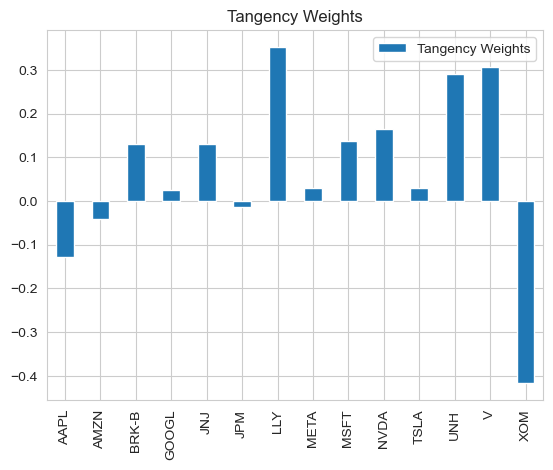

In [6]:
tangency_wts = pmh.calc_tangency_weights(in_sample_assets_excess_returns, return_graphic=True,annual_factor=12)
display(tangency_wts)

,Regularized Weights
AAPL,-0.0147
AMZN,0.0363
BRK-B,0.1092
GOOGL,0.0505
JNJ,0.0992
JPM,0.0537
LLY,0.2149
META,0.0349
MSFT,0.0900
NVDA,0.0717


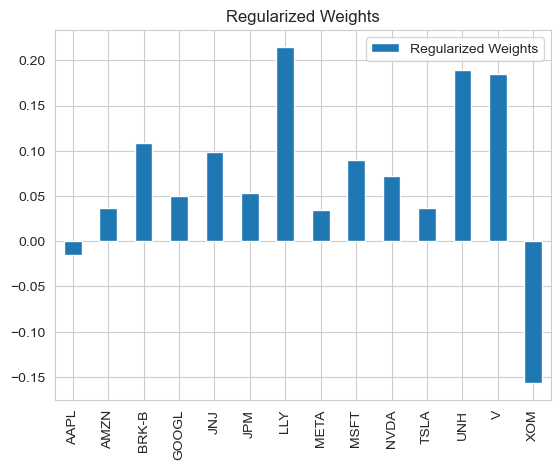

In [7]:
regularized_wts = pmh.calc_tangency_weights(in_sample_assets_excess_returns, return_graphic=True,cov_mat=(1/2),annual_factor=12, name="Regularized")
display(regularized_wts)

In [8]:
pd.concat([tangency_wts, regularized_wts], axis=1).abs().sum().T.to_frame('Absolute Sum of Weights')

,Absolute Sum of Weights
Tangency Weights,2.1977
Regularized Weights,1.3426


### 2.

Calculate the annualized summary statistics (mean, Sharpe, vol) of both portfolios in-sample.


In [9]:
is_wts = pd.concat([tangency_wts, regularized_wts], axis=1)
pmh.calc_summary_statistics(in_sample_assets_excess_returns @ is_wts, 
                            provided_excess_returns=True,
                            annual_factor=12,
                            keep_columns=['Annualized Mean', 'Annualized Vol', 'Annualized Sharpe']).T

,Tangency Weights,Regularized Weights
Annualized Mean,0.3483,0.2766
Annualized Vol,0.1341,0.1142
Annualized Sharpe,2.5979,2.4224


### 3.

Use the weights calculated in question (2.2) to produce portfolio returns out-of-sample for both the Traditional and Regularized portfolio (from January 2019 onwards). 

Report the **last 3 returns** of both portfolios in the out-of-sample (the traditional tangency portfolio and the regularized tangency portfolio).

In [10]:
oos_rets = (out_of_sample_assets_excess_returns @ is_wts).rename(columns={'Tangency Weights': 'Tangency Returns',
                                                                  'Regularized Weights': 'Regularized Returns'})
oos_rets.tail(3).style.format('{:.2%}')

,Tangency Returns,Regularized Returns
date,,
2024-07-31 00:00:00,-1.60%,0.32%
2024-08-31 00:00:00,10.12%,6.46%
2024-09-30 00:00:00,-2.52%,-1.65%


### 4.

Report the annualized summary statistics (Mean, Vol and Sharpe) of both portfolios in the out-of-sample.

Note: you are using the weights optimized for the in-sample and generating statistics with the out-of-sample returns.

In [11]:
pmh.calc_summary_statistics(out_of_sample_assets_excess_returns @ is_wts, 
                            provided_excess_returns=True,
                            annual_factor=12,
                            keep_columns=['Annualized Mean', 'Annualized Vol', 'Annualized Sharpe']).T

,Tangency Weights,Regularized Weights
Annualized Mean,0.3216,0.2687
Annualized Vol,0.2224,0.1763
Annualized Sharpe,1.4462,1.5237


### 5.
Which portfolio has better adjusted by risk returns in the out-of-sample? Could there be a mathematical/optimization reason why one portfolio had better adjusted by risk performance? 

Relate your answer to your findings in question (2.2) (Sum of absolute weights in the traditional and regularized tangency portfolio.)

<span style="color:red;">

The Regularized portfolio exhibited better risk-adjusted returns out-of-sample. This could be explained by the traditional MVO weights solution being overfit in-sample. The Regularization is designed to reduce the overfitting of a traditional MVO. 

Additionally, the poorer risk-adjusted returns of the traditional MVO portfolio could be explained by the reduced leverage of the regularized portfolio, as exhibited in question (2.1). This leverage will naturally lend itself to greater volatility in the portfolio. 

<span>

***

# 3. Hedging and Replication

For this question you will only use data from the sheet `proshares returns`.

The following assets excess returns are available in this sheet:

- **HDG US Equity**: ProShares Hedge Replication ET
- **QAI US Equity**: NYLI Hedge Multi-Strategy Trac
- **SPY US Equity**: SPDR S&P 500 ETF Trust
- **EEM US Equity**: iShares MSCI Emerging Markets
- **EFA US Equity**: iShares MSCI EAFE ETF
- **EUO US Equity**: ProShares UltraShort Euro
- **IWM US Equity**: iShares Russell 2000 ETF
- **SPXU US Equity**: ProShares UltraPro Short S&P 5
- **UPRO US Equity**: ProShares UltraPro S&P 500

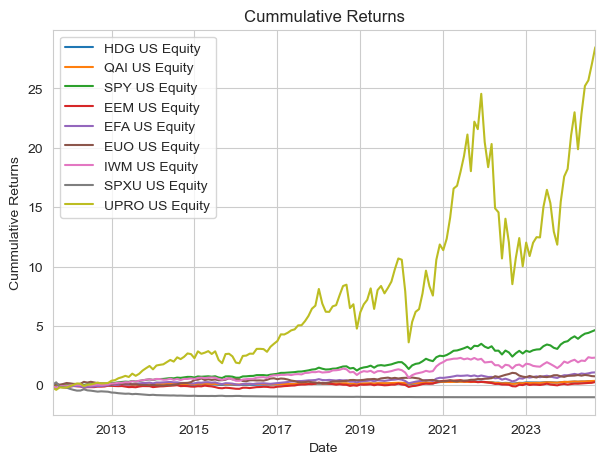

In [12]:
prosx = pmh.read_excel_default("../data/midterm_1_data.xlsx", sheet_name=1)
pmh.calc_cummulative_returns(prosx)

### 1. 

You work at a hedge fund.

Suppose the hedge fund is long $1 million of HDG and wants to hedge the position.

A junior analyst suggests that we can hedge our position by looking at some select ETFs, and then taking a position in the ETFs that will offset the risk of our HDG position.

They pick QAI, SPY, EEM, UPRO, SPXU, IWM, and EFA.

What dollar position would we be taking in each ETF to hedge your HDG position?

In [13]:
hedge_pos = 1000000
hedgex = prosx[['QAI US Equity', 'SPY US Equity', 'EEM US Equity', 'UPRO US Equity', 'SPXU US Equity', 'IWM US Equity', 'EFA US Equity']]

regr = pmh.calc_regression(prosx['HDG US Equity'], hedgex, annual_factor=12)
betas = regr.loc[:, regr.columns.str.contains('Beta')].T
hedge_pos = (hedge_pos * betas)
display(hedge_pos.style.format('${:,.0f}'))

"calc_regression" assumes excess returns to calculate Information and Treynor Ratios


,HDG US Equity
QAI US Equity Beta,"$151,537"
SPY US Equity Beta,"$515,376"
EEM US Equity Beta,"$44,816"
UPRO US Equity Beta,"$-140,222"
SPXU US Equity Beta,"$32,654"
IWM US Equity Beta,"$139,036"
EFA US Equity Beta,"$117,000"


### 2.

#### (7pts)
What is the gross notional of the hedge?

What is the R-squared of the hedge?

What do these two statistics indicate about the practical use of this hedge?

In [14]:
hedge_pos.abs().sum().to_frame('Gross Notional Position').style.format('${:,.0f}')

,Gross Notional Position
HDG US Equity,"$1,140,643"


In [15]:
regr['R-Squared'].to_frame('R-Squared')

,R-Squared
HDG US Equity,0.9129


<span style="color:red;">

These two statistics indicate that the hedge is somewhat practical and could be quite effective.
* The hedge is somewhat practical because the notional hedging position is not much larger than the position being hedged (~14% larger). However, this size could prove infeasible for some smaller managers.

* The hedge should be quite effective because the $R^2$ is quite high. This tells us that the basis risk of the hedge is quite low, so the hedge should be quite effective.

<span>

### 3.

Suppose instead we don't want to hedge our position. We believe that the value of HDG can be *entirely* determined by some combination of the other ETFs. 

So, you propose the following model:

$$
HDG_t = \beta_1 QAI_t + \beta_2 SPY_t + \beta_3 EEM_t + \varepsilon_t
$$

We think any difference between the value of HDG and the value of the ETFs is a mispricing, and will revert to 0 in the future. We call such a strategy "trading the residuals".

Therefore, if $\varepsilon_t > 0$, we should be short HDG and long the basket, and if $\varepsilon_t < 0$, we should be long HDG and short the basket.

Now...
* Run the model specified above and report the $\beta$'s values.
* After, create the "basket" portfolio, using the $\beta$'s as weights (they do not need to add up to one). Report the final three values.

<span style="color:red;">

Assuming that the "final three values" to be reported are the dollar value of the "basket" portfolio as of the last 3 dates in the time series. Also assuming that we are investing in the basket portfolio as of the beginning of the time series. consequently, the final three-values will be the result of cumulative returns over the full time-series.

<span>

In [24]:
basketx = prosx[['QAI US Equity', 'SPY US Equity', 'EEM US Equity']]

basket_regr = pmh.calc_regression(prosx['HDG US Equity'], basketx, annual_factor=12)
print(f'\nR-Squared of basket: {basket_regr['R-Squared'].values[0]}')
basket_betas = basket_regr.loc[:, basket_regr.columns.str.contains('Beta')]
basket_betas.columns = basket_betas.columns.str.replace(' Beta', '', regex=False)
display(basket_betas.T)

"calc_regression" assumes excess returns to calculate Information and Treynor Ratios

R-Squared of basket: 0.8459032161427619


,HDG US Equity
QAI US Equity,0.3415
SPY US Equity,0.1763
EEM US Equity,0.0831


In [30]:
(basketx @ basket_betas.T).rename(columns={'HDG US Equity': 'Hedging Portfolio Returns'}).tail(3).style.format("{:.2%}")

,Hedging Portfolio Returns
date,
2024-07-31 00:00:00,0.67%
2024-08-31 00:00:00,0.75%
2024-09-30 00:00:00,1.34%


### 4.

#### (8pts)

Construct the strategy indicated by the approach in the previous problem.

For a given period $t$:
- if the $\varepsilon_t \leq 0$ (is negative or equal to 0), you should be long HDG 200% in HDG and short 100% in the basket portfolio **in period $t+1$**.
- if the $\varepsilon_t > 0$ (is positive), you should be long 200% in the basket portfolio and short 100% **in HDG in period $t+1$**.

Do not worry about the look forward bias: in this scenario, you should run the model only once with the entire dataset and define your $\varepsilon_t$ for any $t$ also considering the model that has acess to data in $t+1, t+2, ...$ to make the calculation.  

Report the annualized summary statistics of this strategy (Mean, Vol and Sharpe).

### 5.

On a different matter, we are now studying QAI and want to track (replicate) it using the other available ETFs.

Use an intercept and report:

- $\beta$ (and the sum of $\beta$'s absolute value).
- $\alpha$ and Information Ratio.
- $R^2$.
- Correlation matrix between the assets used to replicate QAI.

In [24]:
regr = pmh.calc_regression(prosx['QAI US Equity'], prosx.drop(columns='QAI US Equity'), annual_factor=12)
display(regr.T)

"calc_regression" assumes excess returns to calculate Information and Treynor Ratios


,QAI US Equity
Alpha,-0.0005
Annualized Alpha,-0.0063
R-Squared,0.8420
HDG US Equity Beta,0.2315
SPY US Equity Beta,0.5651
EEM US Equity Beta,0.0478
EFA US Equity Beta,0.0326
EUO US Equity Beta,-0.0205
IWM US Equity Beta,-0.0002
SPXU US Equity Beta,0.0511


The highest correlation (99.65%) is between UPRO US Equity and SPY US Equity
The lowest correlation (-95.55%) is between SPY US Equity and SPXU US Equity


<Axes: >

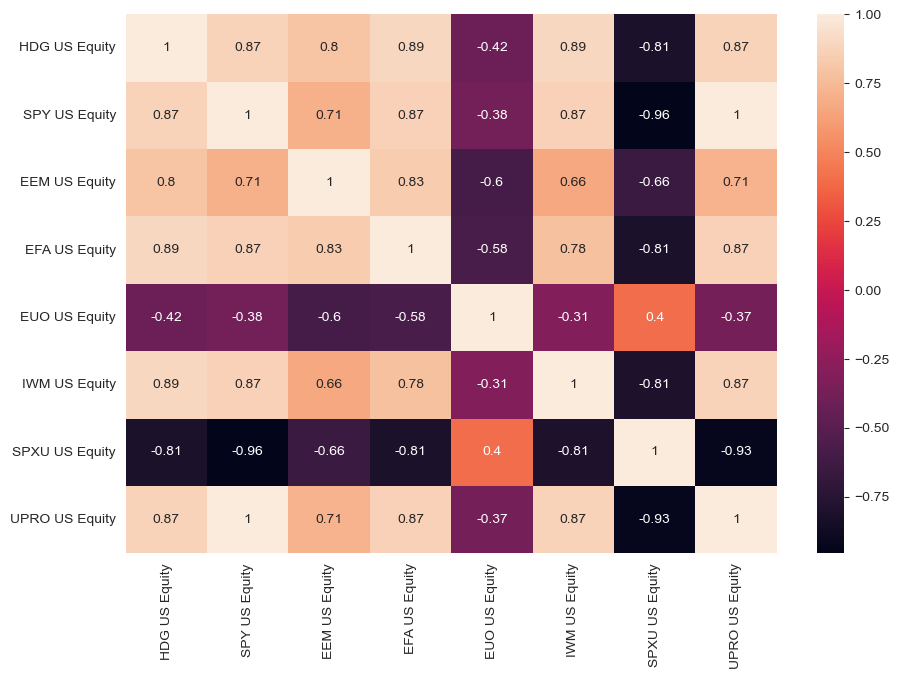

In [25]:
pmh.calc_correlations(prosx.drop(columns='QAI US Equity'))

In [27]:
betas = regr.loc[:, regr.columns.str.contains('Beta')].T
betas.abs().sum().to_frame('Absolute Notional Exposure')

,Absolute Notional Exposure
QAI US Equity,1.0438


### 6.

Explain how good is your replication, pointing out at least one good or bad argument related to each of the statistics mentioned in the bullet points above (thus, you should have at least 4 arguments).

<span style="color:red;">

* My replication good because the absolute exposure to the hedge position would only have to be4% larger than the QAI position. However, if this is a small portfolio, then it may be infeasible because we do not have enough capital to allocate to this position.

* My replication is good because the alpha quite small and, consequently, the information ratio is quite large. 

* My replication $R^2$ is fairly high, which means it captures most of the variation in the QAI ETF. However, it is not that high for an LFD regression, and so it could miss tracking the QAI position over time.

* My replication has some assets that are highly correlated with one another (which could lead to volatility in returns), but it also has many assets with negative correlation to one another. So it should have a somewhat smooth return profile.

<span>

***

# 4. 

The data in sheet `fx carry excess returns` has **excess** daily returns for trading currencies.
* You **do NOT need** to know anything about FX, currency, or the underlying strategies.
* Rather, just take these return series as given.

For the problems below, we will **only use** the `JPY` series.

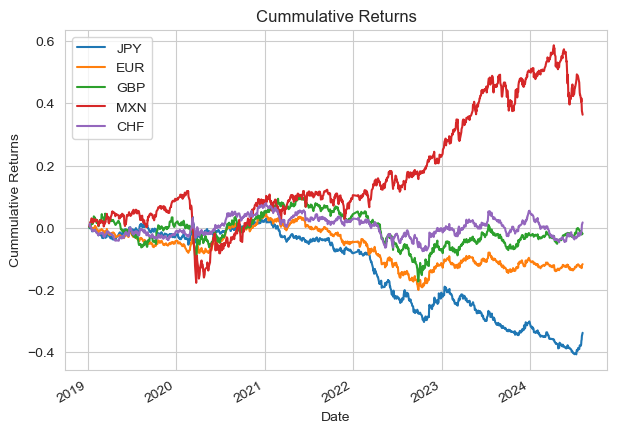

In [17]:
forexx = pmh.read_excel_default("../data/midterm_1_data.xlsx", sheet_name=2)
pmh.calc_cummulative_returns(forexx)

### 1.

Calculate the `1%` VaR as follows...

Empirical VaR:
* At every point in time, calculate the `1st` quantile of the returns up to that point.
* No need to scale the answers.
  
Report the VaR for the final date of the sample.

In [18]:
jpyx = forexx['JPY'].to_frame('JPY')
jpyx['Historical 1% VaR'] = jpyx['JPY'].shift(1).expanding(min_periods=1).quantile(0.01)
jpyx.tail(1).style.format("{:.2%}")

,JPY,Historical 1% VaR
date,,
2024-08-05 00:00:00,1.60%,-1.72%


### 2.

Now calculate the `normal VaR` of `JPY` as follows,

$$\text{Normal VaR (1\%)} = -2.33\, \sigma_t$$

where $\sigma_t$ is estimated with
* rolling volatility.
* using a window of `233` days.
* without using a sample mean.

Report the VaR for the final `3 days` of the sample.

In [19]:
jpyx['Rolling 1% Normal VaR'] = -2.33 * np.sqrt((jpyx.JPY**2).shift(1).rolling(233).mean())
jpyx.tail(3).style.format("{:.2%}")

,JPY,Historical 1% VaR,Rolling 1% Normal VaR
date,,,
2024-08-01 00:00:00,0.40%,-1.72%,-1.34%
2024-08-02 00:00:00,1.92%,-1.72%,-1.34%
2024-08-05 00:00:00,1.60%,-1.72%,-1.36%


### 3.

Now calculate the `normal VaR` of `JPY` as follows,

$$\text{Normal VaR (1\%)} = -2.33\, \sigma_t$$

where $\sigma_t$ is estimated with
* EWMA volatility
* using $\lambda = 0.94$.
* without using a sample mean.

Report the VaR for the final `3 days` of the sample.

In [20]:
vol_ewma = pmh.calc_ewma_volatility(excess_returns=jpyx.JPY, initial_vol=0.005)
jpyx['EWMA 1% Normal VaR'] = vol_ewma * -2.33
jpyx.tail(3).style.format("{:.2%}")

,JPY,Historical 1% VaR,Rolling 1% Normal VaR,EWMA 1% Normal VaR
date,,,,
2024-08-01 00:00:00,0.40%,-1.72%,-1.34%,-1.74%
2024-08-02 00:00:00,1.92%,-1.72%,-1.34%,-2.01%
2024-08-05 00:00:00,1.60%,-1.72%,-1.36%,-2.16%


### 4.

Make a plot of the three timeseries of your VaR estimates.

Succinctly point out the pros / cons of these approaches.

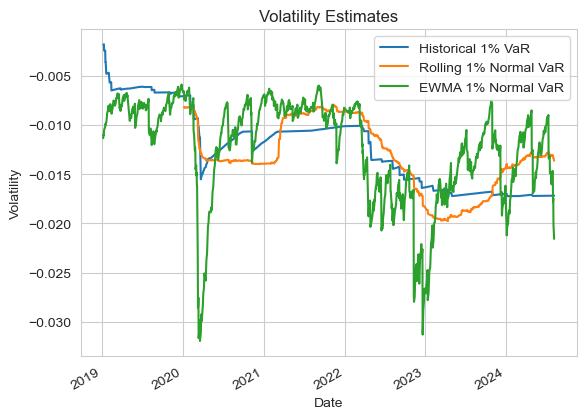

In [21]:
(jpyx[['Historical 1% VaR', 'Rolling 1% Normal VaR', 'EWMA 1% Normal VaR']]
 .plot(title='Volatility Estimates', ylabel='Volatility', xlabel='Date'))
plt.show()

<span style="color:red;">

* Historical VaR: 
1. Pros - Takes into account the entire data sample and is distribution free (i.e: free of distributional bias).
1. Cons - Slowest to react and often overly conservative. Also very sensitive to new data coming into the tails (evidence is the precipitous drop in early 2022.)

* Rolling 1% Normal VaR:
1. Pros - More reactive than historical VaR as it only looks at more recent history. Often is less unnecessarily conservative.
1. Cons - Does not take into account full data sample so may be overly rosy. Also makes assumptions about the returns having a normal distribution, which we know is not very reflective of reality.

* EWMA 1% Normal VaR:
1. Pros - Most reactive as it puts additional weight on more recent observations. This often leads it be the least convervative.
1. Cons - Diminishes the importance of the old data samples, and is therefore biased toward more recent regimes. This makes this method nearly blind to extreme observations that may have happened in the early stages of the observed period.

<span>

### 5.

What statistic do we use to judge the performance of a VaR model?

Estimate and report this statistic across the VaR methods.

Which VaR model do you find is best?

In [22]:
# Hit Ratio used to judge performance of VaR Model
var_temp = jpyx[['Historical 1% VaR', 'Rolling 1% Normal VaR', 'EWMA 1% Normal VaR']].dropna()
hist_hit_ratio = sum(jpyx.loc[var_temp.index, 'JPY'] < var_temp['Historical 1% VaR']) / len(var_temp)
roll_hit_ratio = sum(jpyx.loc[var_temp.index, 'JPY'] < var_temp['Rolling 1% Normal VaR']) / len(var_temp)
ewma_hit_ratio = sum(jpyx.loc[var_temp.index, 'JPY'] < var_temp['EWMA 1% Normal VaR']) / len(var_temp)

print(f'Historic VaR Hit Ratio: {hist_hit_ratio:.2%}\nRolling Normal VaR Hit Ratio: {roll_hit_ratio:.2%}\nEWMA Normal VaR Hit Ratio: {ewma_hit_ratio:.2%}')

Historic VaR Hit Ratio: 2.05%
Rolling Normal VaR Hit Ratio: 2.52%
EWMA Normal VaR Hit Ratio: 1.21%


***